In [2]:
import fastf1
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from xgboost import XGBClassifier

# Enable caching (optional but speeds up repeat runs)
fastf1.Cache.enable_cache('./cache')

#### Pull Session Data

In [3]:
def load_race_session(year, race):
    session = fastf1.get_session(year, race, 'R')
    session.load()
    return session

In [4]:
race = 'Italian Grand Prix'

In [5]:
sessions = []
for year in [2022, 2023, 2024]:
    session = load_race_session(year, race)
    session.laps['Year'] = year  # add a year column
    sessions.append(session)

# Combine all laps into one DataFrame
all_laps = pd.concat([s.laps for s in sessions], ignore_index=True)
print(f"Total laps loaded: {len(all_laps)}")

core           INFO 	Loading data for Italian Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '16', '63', '55', '44', '11', '4', '10', '45', '24', '31', '47', '77', '22', '6', '20', '3', '18', '14', '5']
core           INFO 	Loading data for Italian Grand Prix - Race

Total laps loaded: 2937


In [6]:
all_laps.head()

,Time,Driver,DriverNumber,LapTime,LapNumber,Stint,PitOutTime,PitInTime,Sector1Time,Sector2Time,...,Team,LapStartTime,LapStartDate,TrackStatus,Position,Deleted,DeletedReason,FastF1Generated,IsAccurate,Year
0,0 days 01:03:59.211000,VER,1,0 days 00:01:30.827000,1.0,1.0,NaT,NaT,NaT,0 days 00:00:30.903000,...,Red Bull Racing,0 days 01:02:28.137000,2022-09-11 13:03:28.378,1,4.0,False,,False,False,2022
1,0 days 01:05:25.612000,VER,1,0 days 00:01:26.401000,2.0,1.0,NaT,NaT,0 days 00:00:28.387000,0 days 00:00:29.504000,...,Red Bull Racing,0 days 01:03:59.211000,2022-09-11 13:04:59.452,1,3.0,False,,False,True,2022
2,0 days 01:06:51.793000,VER,1,0 days 00:01:26.181000,3.0,1.0,NaT,NaT,0 days 00:00:28.205000,0 days 00:00:29.457000,...,Red Bull Racing,0 days 01:05:25.612000,2022-09-11 13:06:25.853,1,3.0,False,,False,True,2022
3,0 days 01:08:17.575000,VER,1,0 days 00:01:25.782000,4.0,1.0,NaT,NaT,0 days 00:00:27.936000,0 days 00:00:29.170000,...,Red Bull Racing,0 days 01:06:51.793000,2022-09-11 13:07:52.034,1,3.0,False,,False,True,2022
4,0 days 01:09:43.087000,VER,1,0 days 00:01:25.512000,5.0,1.0,NaT,NaT,0 days 00:00:27.904000,0 days 00:00:29.341000,...,Red Bull Racing,0 days 01:08:17.575000,2022-09-11 13:09:17.816,1,2.0,False,,False,True,2022


In [7]:
all_laps.shape

(2937, 32)

In [8]:
all_laps.columns

Index(['Time', 'Driver', 'DriverNumber', 'LapTime', 'LapNumber', 'Stint',
       'PitOutTime', 'PitInTime', 'Sector1Time', 'Sector2Time', 'Sector3Time',
       'Sector1SessionTime', 'Sector2SessionTime', 'Sector3SessionTime',
       'SpeedI1', 'SpeedI2', 'SpeedFL', 'SpeedST', 'IsPersonalBest',
       'Compound', 'TyreLife', 'FreshTyre', 'Team', 'LapStartTime',
       'LapStartDate', 'TrackStatus', 'Position', 'Deleted', 'DeletedReason',
       'FastF1Generated', 'IsAccurate', 'Year'],
      dtype='object')

In [9]:
all_laps.dtypes

Time                  timedelta64[ns]
Driver                         object
DriverNumber                   object
LapTime               timedelta64[ns]
LapNumber                     float64
Stint                         float64
PitOutTime            timedelta64[ns]
PitInTime             timedelta64[ns]
Sector1Time           timedelta64[ns]
Sector2Time           timedelta64[ns]
Sector3Time           timedelta64[ns]
Sector1SessionTime    timedelta64[ns]
Sector2SessionTime    timedelta64[ns]
Sector3SessionTime    timedelta64[ns]
SpeedI1                       float64
SpeedI2                       float64
SpeedFL                       float64
SpeedST                       float64
IsPersonalBest                 object
Compound                       object
TyreLife                      float64
FreshTyre                        bool
Team                           object
LapStartTime          timedelta64[ns]
LapStartDate           datetime64[ns]
TrackStatus                    object
Position    

In [10]:
print(all_laps.iloc[0])

Time                      0 days 01:03:59.211000
Driver                                       VER
DriverNumber                                   1
LapTime                   0 days 00:01:30.827000
LapNumber                                    1.0
Stint                                        1.0
PitOutTime                                   NaT
PitInTime                                    NaT
Sector1Time                                  NaT
Sector2Time               0 days 00:00:30.903000
Sector3Time               0 days 00:00:28.827000
Sector1SessionTime                           NaT
Sector2SessionTime        0 days 01:03:30.484000
Sector3SessionTime        0 days 01:03:59.211000
SpeedI1                                    315.0
SpeedI2                                    316.0
SpeedFL                                    311.0
SpeedST                                    286.0
IsPersonalBest                             False
Compound                                    SOFT
TyreLife            

#### Filter out invalid laps

In [11]:
def filter_valid_laps(laps):
    valid_laps = laps.copy()

    # 1. Remove pit in/out laps
    valid_laps = valid_laps[valid_laps['PitInTime'].isna() & valid_laps['PitOutTime'].isna()]

    # 2. Remove laps with SC/VSC, or yellow/red flag
    '''
    1: Track Clear
    2: Yellow flag
    4: Safety Car
    5: Red flag
    6: Virtual Safety Car deployed
    7: Virtual Safety Car ending
    '''
    if 'TrackStatus' in valid_laps.columns:
        valid_laps = valid_laps[~valid_laps['TrackStatus'].isin(['2', '4', '5', '6', '7'])]

    # 3. Remove laps with missing data
    valid_laps = valid_laps.dropna(subset=['LapTime', 'Compound'])

    return valid_laps

In [12]:
filtered_laps = filter_valid_laps(all_laps)

print(f"Laps before filtering: {len(all_laps)}")
print(f"Laps after filtering:  {len(filtered_laps)}")

filtered_laps[['Driver', 'LapNumber', 'Stint', 'Compound', 'LapTime', 'TrackStatus', 'Year']].head(10)

Laps before filtering: 2937
Laps after filtering:  2672


,Driver,LapNumber,Stint,Compound,LapTime,TrackStatus,Year
0,VER,1.0,1.0,SOFT,0 days 00:01:30.827000,1,2022
1,VER,2.0,1.0,SOFT,0 days 00:01:26.401000,1,2022
2,VER,3.0,1.0,SOFT,0 days 00:01:26.181000,1,2022
3,VER,4.0,1.0,SOFT,0 days 00:01:25.782000,1,2022
4,VER,5.0,1.0,SOFT,0 days 00:01:25.512000,1,2022
5,VER,6.0,1.0,SOFT,0 days 00:01:25.660000,1,2022
6,VER,7.0,1.0,SOFT,0 days 00:01:25.297000,1,2022
7,VER,8.0,1.0,SOFT,0 days 00:01:25.618000,1,2022
8,VER,9.0,1.0,SOFT,0 days 00:01:25.886000,1,2022
9,VER,10.0,1.0,SOFT,0 days 00:01:25.953000,1,2022


#### Check if there is a need to filter outliers

In [13]:
# Make a new column in seconds for easier plotting and math
filtered_laps['LapTimeSeconds'] = filtered_laps['LapTime'].dt.total_seconds()

In [14]:
# Compute lap deltas within each stint
def compute_lap_delta(group):
    group = group.sort_values('LapNumber').copy()
    group['LapDelta'] = group['LapTimeSeconds'].diff()
    return group

# Apply to entire dataset
laps_with_deltas = filtered_laps.groupby(['Driver', 'Stint', 'Year'], group_keys=False).apply(compute_lap_delta)

# Flag laps with a large jump (e.g., delta > 10 seconds vs previous lap)
potential_outliers = laps_with_deltas[laps_with_deltas['LapDelta'] > 10]

print(f"Found {len(potential_outliers)} laps with a spike > 10s vs previous lap")
potential_outliers[['Driver', 'Year', 'Stint', 'LapNumber', 'LapTimeSeconds', 'LapDelta']]

Found 25 laps with a spike > 10s vs previous lap


/var/folders/cl/x4g3r0nj7qvb_h2ft5kt0zhw0000gn/T/ipykernel_13529/3906787222.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  laps_with_deltas = filtered_laps.groupby(['Driver', 'Stint', 'Year'], group_keys=False).apply(compute_lap_delta)


,Driver,Year,Stint,LapNumber,LapTimeSeconds,LapDelta
11,VER,2022,1.0,12.0,107.245,21.387
64,GAS,2022,1.0,12.0,110.771,23.322
99,GAS,2022,2.0,47.0,110.410,23.666
152,PER,2022,3.0,47.0,103.427,19.397
170,ALO,2022,1.0,12.0,110.187,22.439
254,STR,2022,1.0,12.0,110.745,22.633
293,MAG,2022,1.0,12.0,110.858,22.437
345,TSU,2022,1.0,12.0,111.102,22.568
397,ZHO,2022,1.0,12.0,110.966,23.257
432,ZHO,2022,2.0,47.0,111.203,24.241


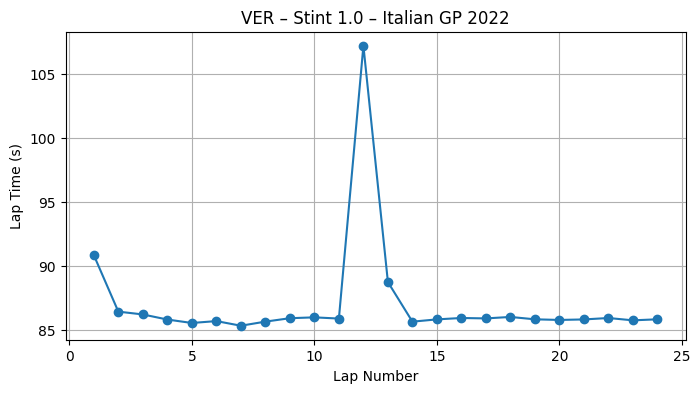

In [15]:
# Choose a sample outlier
if not potential_outliers.empty:
    example = potential_outliers.iloc[0]
    drv = example['Driver']
    stint = example['Stint']
    year = example['Year']

    # Plot the full stint
    sample = filtered_laps[(filtered_laps['Driver'] == drv) &
                           (filtered_laps['Stint'] == stint) &
                           (filtered_laps['Year'] == year)]

    plt.figure(figsize=(8, 4))
    plt.plot(sample['LapNumber'], sample['LapTimeSeconds'], marker='o')
    plt.title(f"{drv} – Stint {stint} – Italian GP {year}")
    plt.xlabel("Lap Number")
    plt.ylabel("Lap Time (s)")
    plt.grid(True)
    plt.show()

#### Shift from filtering stint to lap outliers

In [16]:
# Set a spike threshold (e.g., +10 sec delta from previous lap)
spike_threshold = 10.0

# Reuse laps_with_deltas from before
spiked_laps = laps_with_deltas[laps_with_deltas['LapDelta'] > spike_threshold]

# Drop just those laps from the main dataset
filtered_cleaned_laps = filtered_laps[~filtered_laps.index.isin(spiked_laps.index)]

print(f"Laps before cleaning spikes: {len(filtered_laps)}")
print(f"Laps after cleaning spikes:  {len(filtered_cleaned_laps)}")

Laps before cleaning spikes: 2672
Laps after cleaning spikes:  2647


#### Add weather data

In [17]:
def enrich_with_weather(laps_df, sessions):
    enriched = []

    for session in sessions:
        weather_df = session.weather_data.copy()
        weather_df['Time'] = pd.to_timedelta(weather_df['Time'])  # ensure proper type

        # Match weather per lap
        session_laps = laps_df[laps_df['Year'] == session.date.year]
        session_laps = session_laps.copy()
        session_laps['Time'] = session_laps['LapStartTime'].dt.total_seconds()

        # Convert weather time to seconds to merge
        weather_df['WeatherTime'] = weather_df['Time'].dt.total_seconds()

        # Merge each lap with nearest weather row (on absolute time delta)
        session_laps = pd.merge_asof(
            session_laps.sort_values('Time'),
            weather_df.sort_values('WeatherTime'),
            left_on='Time',
            right_on='WeatherTime',
            direction='nearest',
            tolerance=60  # 1 minute
        )

        enriched.append(session_laps)

    return pd.concat(enriched, ignore_index=True)

In [18]:
# Run the weather enrichment
filtered_laps_with_weather = enrich_with_weather(filtered_cleaned_laps, sessions)

In [19]:
filtered_laps_with_weather.shape

(2647, 42)

In [20]:
filtered_laps_with_weather.columns

Index(['Time_x', 'Driver', 'DriverNumber', 'LapTime', 'LapNumber', 'Stint',
       'PitOutTime', 'PitInTime', 'Sector1Time', 'Sector2Time', 'Sector3Time',
       'Sector1SessionTime', 'Sector2SessionTime', 'Sector3SessionTime',
       'SpeedI1', 'SpeedI2', 'SpeedFL', 'SpeedST', 'IsPersonalBest',
       'Compound', 'TyreLife', 'FreshTyre', 'Team', 'LapStartTime',
       'LapStartDate', 'TrackStatus', 'Position', 'Deleted', 'DeletedReason',
       'FastF1Generated', 'IsAccurate', 'Year', 'LapTimeSeconds', 'Time_y',
       'AirTemp', 'Humidity', 'Pressure', 'Rainfall', 'TrackTemp',
       'WindDirection', 'WindSpeed', 'WeatherTime'],
      dtype='object')

#### Add telemetry data aggregated per lap

In [21]:
def aggregate_telemetry(session, laps_df):
    all_features = []

    # Filter laps for this session year
    session_laps = laps_df[laps_df['Year'] == session.date.year]

    for _, lap_row in session_laps.iterrows():
        try:
            lap = session.laps[
                (session.laps['Driver'] == lap_row['Driver']) &
                (session.laps['LapNumber'] == lap_row['LapNumber'])
            ].iloc[0]

            telemetry = lap.get_car_data().add_distance()

            # Aggregate telemetry stats
            features = {
                'Driver': lap_row['Driver'],
                'LapNumber': lap_row['LapNumber'],
                'Stint': lap_row['Stint'],
                'Year': lap_row['Year'],
                'Speed_Mean': telemetry['Speed'].mean(),
                'Speed_Max': telemetry['Speed'].max(),
                'Speed_Std': telemetry['Speed'].std(),
                'RPM_Mean': telemetry['RPM'].mean(),
                'Throttle_Mean': telemetry['Throttle'].mean(),
                'Throttle_Std': telemetry['Throttle'].std(),
                'Brake_Mean': telemetry['Brake'].mean(),
                'Gear_Mean': telemetry['nGear'].mean(),
                'Distance_Total': telemetry['Distance'].max(),  # for per-segment modelling
                'DRS_active_pct': telemetry['DRS'].mean() if 'DRS' in telemetry else 0
            }

            all_features.append(features)

        except (IndexError, AttributeError, KeyError):
            continue  # Skip if data missing

    return pd.DataFrame(all_features)

In [22]:
# Loop through each session and aggregate telemetry
telemetry_agg_dfs = []
for session in sessions:
    telemetry_agg_dfs.append(aggregate_telemetry(session, filtered_laps_with_weather))
    print(f"Aggregated telemetry for {session.date.year}.")

# Combine telemetry features
lap_telemetry_df = pd.concat(telemetry_agg_dfs, ignore_index=True)

Aggregated telemetry for 2022.
Aggregated telemetry for 2023.
Aggregated telemetry for 2024.


In [23]:
lap_telemetry_df.shape

(2647, 14)

In [24]:
lap_telemetry_df.columns

Index(['Driver', 'LapNumber', 'Stint', 'Year', 'Speed_Mean', 'Speed_Max',
       'Speed_Std', 'RPM_Mean', 'Throttle_Mean', 'Throttle_Std', 'Brake_Mean',
       'Gear_Mean', 'Distance_Total', 'DRS_active_pct'],
      dtype='object')

In [25]:
# Merge telemetry features into laps+weather
final_lap_df = pd.merge(
    filtered_laps_with_weather,
    lap_telemetry_df,
    on=['Driver', 'LapNumber', 'Stint', 'Year'],
    how='inner'
)

In [26]:
final_lap_df.shape

(2647, 52)

In [27]:
final_lap_df.columns

Index(['Time_x', 'Driver', 'DriverNumber', 'LapTime', 'LapNumber', 'Stint',
       'PitOutTime', 'PitInTime', 'Sector1Time', 'Sector2Time', 'Sector3Time',
       'Sector1SessionTime', 'Sector2SessionTime', 'Sector3SessionTime',
       'SpeedI1', 'SpeedI2', 'SpeedFL', 'SpeedST', 'IsPersonalBest',
       'Compound', 'TyreLife', 'FreshTyre', 'Team', 'LapStartTime',
       'LapStartDate', 'TrackStatus', 'Position', 'Deleted', 'DeletedReason',
       'FastF1Generated', 'IsAccurate', 'Year', 'LapTimeSeconds', 'Time_y',
       'AirTemp', 'Humidity', 'Pressure', 'Rainfall', 'TrackTemp',
       'WindDirection', 'WindSpeed', 'WeatherTime', 'Speed_Mean', 'Speed_Max',
       'Speed_Std', 'RPM_Mean', 'Throttle_Mean', 'Throttle_Std', 'Brake_Mean',
       'Gear_Mean', 'Distance_Total', 'DRS_active_pct'],
      dtype='object')

In [28]:
final_lap_df.head()

,Time_x,Driver,DriverNumber,LapTime,LapNumber,Stint,PitOutTime,PitInTime,Sector1Time,Sector2Time,...,Speed_Mean,Speed_Max,Speed_Std,RPM_Mean,Throttle_Mean,Throttle_Std,Brake_Mean,Gear_Mean,Distance_Total,DRS_active_pct
0,3748.137,VER,1,0 days 00:01:30.827000,1.0,1.0,NaT,NaT,NaT,0 days 00:00:30.903000,...,217.158358,316.0,78.673365,10427.568915,70.214076,42.652818,0.199413,5.363636,5499.228611,1.0
1,3748.137,ALO,14,0 days 00:01:33.058000,1.0,1.0,NaT,NaT,NaT,0 days 00:00:32.132000,...,211.614286,325.0,79.339012,10438.362857,70.942857,41.055238,0.180000,5.060000,5490.956111,1.0
2,3748.137,LEC,16,0 days 00:01:28.085000,1.0,1.0,NaT,NaT,NaT,0 days 00:00:29.537000,...,222.798193,311.0,75.100687,10379.108434,75.391566,38.674374,0.147590,5.713855,5448.978056,1.0
3,3748.137,STR,18,0 days 00:01:34.774000,1.0,1.0,NaT,NaT,NaT,0 days 00:00:31.881000,...,208.723464,323.0,80.000729,10063.888268,63.821229,42.078310,0.000000,5.505587,5533.805278,1.0
4,3748.137,MAG,20,0 days 00:01:35.277000,1.0,1.0,NaT,NaT,NaT,0 days 00:00:31.940000,...,208.480556,326.0,80.934512,10078.941667,67.425000,41.964834,0.202778,5.383333,5560.449167,1.0


In [29]:
final_lap_df[final_lap_df['Driver']=='VER']

,Time_x,Driver,DriverNumber,LapTime,LapNumber,Stint,PitOutTime,PitInTime,Sector1Time,Sector2Time,...,Speed_Mean,Speed_Max,Speed_Std,RPM_Mean,Throttle_Mean,Throttle_Std,Brake_Mean,Gear_Mean,Distance_Total,DRS_active_pct
0,3748.137,VER,1,0 days 00:01:30.827000,1.0,1.0,NaT,NaT,NaT,0 days 00:00:30.903000,...,217.158358,316.0,78.673365,10427.568915,70.214076,42.652818,0.199413,5.363636,5499.228611,1.000000
23,3839.211,VER,1,0 days 00:01:26.401000,2.0,1.0,NaT,NaT,0 days 00:00:28.387000,0 days 00:00:29.504000,...,238.486154,320.0,69.862413,10463.633846,74.446154,41.017171,0.150769,6.089231,5721.408611,1.000000
42,3925.612,VER,1,0 days 00:01:26.181000,3.0,1.0,NaT,NaT,0 days 00:00:28.205000,0 days 00:00:29.457000,...,241.705521,322.0,67.599175,10474.085890,75.806748,40.649527,0.144172,6.208589,5723.053333,0.340491
62,4011.793,VER,1,0 days 00:01:25.782000,4.0,1.0,NaT,NaT,0 days 00:00:27.936000,0 days 00:00:29.170000,...,239.080386,335.0,72.524856,10528.823151,72.173633,42.015229,0.170418,6.073955,5739.470278,2.257235
82,4097.575,VER,1,0 days 00:01:25.512000,5.0,1.0,NaT,NaT,0 days 00:00:27.904000,0 days 00:00:29.341000,...,241.086687,347.0,72.039878,10536.557276,76.684211,39.581420,0.142415,6.114551,5714.658611,1.145511
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2565,7455.037,VER,1,0 days 00:01:22.584000,49.0,3.0,NaT,NaT,0 days 00:00:27.341000,0 days 00:00:27.980000,...,251.587459,333.0,70.129668,10576.323432,77.676568,39.162097,0.135314,6.425743,5732.873611,0.000000
2584,7537.621,VER,1,0 days 00:01:22.585000,50.0,3.0,NaT,NaT,0 days 00:00:27.313000,0 days 00:00:28.095000,...,248.080386,332.0,70.958757,10584.823151,76.604502,39.695387,0.144695,6.308682,5720.848056,0.000000
2602,7620.206,VER,1,0 days 00:01:22.574000,51.0,3.0,NaT,NaT,0 days 00:00:27.291000,0 days 00:00:28.043000,...,249.379085,333.0,70.736872,10574.839869,76.820261,39.569284,0.150327,6.362745,5743.789444,0.000000
2620,7702.780,VER,1,0 days 00:01:22.920000,52.0,3.0,NaT,NaT,0 days 00:00:27.286000,0 days 00:00:28.412000,...,245.374593,334.0,73.170852,10494.980456,73.136808,41.285165,0.172638,6.309446,5712.915000,0.000000


#### Filter features for model use

In [30]:
# Check if there was rain
final_lap_df['Rainfall'].value_counts()

Rainfall
False    2647
Name: count, dtype: int64

In [31]:
# Find scrubbed tyres
freshtyre_ct_df = final_lap_df[
                      (final_lap_df['LapNumber'] == 1) &
                      (final_lap_df['FreshTyre'] == False) &
                      (final_lap_df['Stint'] == 1)
                  ]

freshtyre_ct_df.shape

# Scrubbed tyres heat up faster -> Better grip in first few laps
# Teams have a limited number of sets per compound across the weekend
# Keep 'FreshTyre' feature

(14, 52)

In [32]:
features_to_keep = [
    # Context
    'Driver', 'Year', 'LapNumber', 'Stint', 'TyreLife', 'FreshTyre', 'Compound',
    
    # Weather
    'TrackTemp', 'AirTemp', 'Humidity', 'WindSpeed', 'Pressure',

    # Telemetry Aggregates
    'Speed_Mean', 'Speed_Max', 'Speed_Std',
    'Throttle_Mean', 'Throttle_Std', 'Brake_Mean',
    'RPM_Mean', 'Gear_Mean', 'DRS_active_pct',

    # Meta - Strategy Features
    'Team', 'Position',

    # For label calculation:
    'LapTimeSeconds'
]

In [33]:
final_df = final_lap_df[features_to_keep]

In [34]:
final_df_copy = final_lap_df[features_to_keep].copy()

In [35]:
final_df.shape

(2647, 24)

In [36]:
final_df.columns

Index(['Driver', 'Year', 'LapNumber', 'Stint', 'TyreLife', 'FreshTyre',
       'Compound', 'TrackTemp', 'AirTemp', 'Humidity', 'WindSpeed', 'Pressure',
       'Speed_Mean', 'Speed_Max', 'Speed_Std', 'Throttle_Mean', 'Throttle_Std',
       'Brake_Mean', 'RPM_Mean', 'Gear_Mean', 'DRS_active_pct', 'Team',
       'Position', 'LapTimeSeconds'],
      dtype='object')

#### Visualize 'LapTimeSeconds' for Label Engineering

In [37]:
# Find the best lap number by driver, stint, and year
best_lap_indices = (
    final_df.groupby(['Driver', 'Stint', 'Year'])['LapTimeSeconds']
    .idxmin()
)

best_laps = final_df.loc[best_lap_indices, ['Driver', 'Stint', 'Year', 'LapNumber', 'LapTimeSeconds']]
best_laps.rename(columns={'LapNumber': 'BestLapNumber'}, inplace=True)

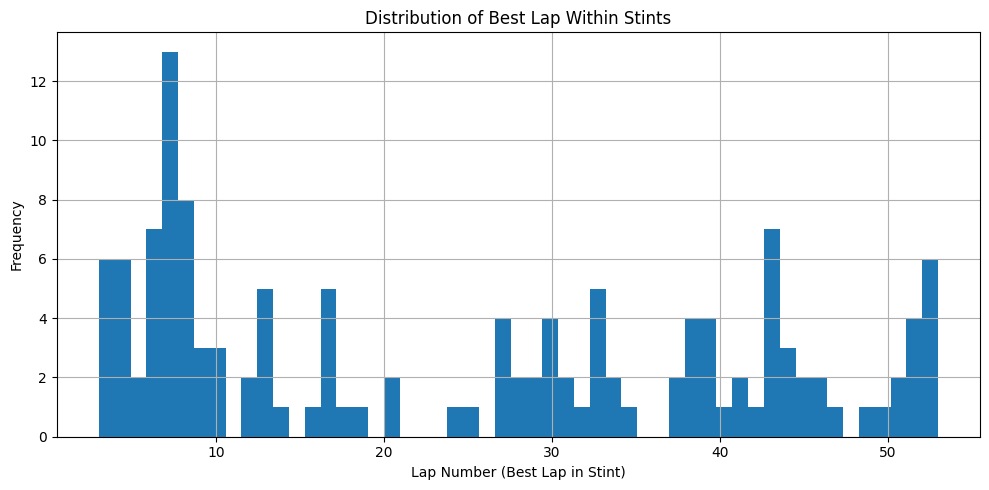

In [38]:
# Plot best lap distribution
plt.figure(figsize=(10, 5))
plt.hist(best_laps['BestLapNumber'], bins=53)
plt.title('Distribution of Best Lap Within Stints')
plt.xlabel('Lap Number (Best Lap in Stint)')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

#### Calculate Lap Time Fall Off

In [39]:
def compute_lap_falloff(df):
    df = df.copy()
    df['LapTimeFalloff'] = None

    for (driver, stint, year), group in df.groupby(['Driver', 'Stint', 'Year']):
        group = group.sort_values('LapNumber')
        first_lap_time = group['LapTimeSeconds'].iloc[0]
        df.loc[group.index, 'LapTimeFalloff'] = group['LapTimeSeconds'] - first_lap_time

    return df

In [40]:
final_df = compute_lap_falloff(final_df)

#### Apply Fuel Correction

In [41]:
# Use Italian Grand Prix for fuel burn assumption
FUEL_BURN_PER_LAP = 1.82  # kg
FUEL_TIME_GAIN_PER_KG = 0.03  # sec/kg

def apply_fuel_correction(df):
    df = df.copy()
    
    # Estimate fuel burned since start of stint
    df['FuelBurned'] = (df['LapNumber'] - df.groupby(['Driver', 'Stint', 'Year'])['LapNumber'].transform('min')) * FUEL_BURN_PER_LAP
    
    # Adjust lap time falloff by subtracting the performance gain due to reduced weight
    df['LapTimeFalloff_FuelAdjusted'] = df['LapTimeFalloff'] - (df['FuelBurned'] * FUEL_TIME_GAIN_PER_KG)
    
    return df

In [42]:
final_df = apply_fuel_correction(final_df)

In [43]:
final_df[final_df['Driver']=='VER'][['LapNumber', 'LapTimeSeconds', 'LapTimeFalloff', 'FuelBurned', 'LapTimeFalloff_FuelAdjusted']].head(10)

,LapNumber,LapTimeSeconds,LapTimeFalloff,FuelBurned,LapTimeFalloff_FuelAdjusted
0,1.0,90.827,0.0,0.00,0.0
23,2.0,86.401,-4.426,1.82,-4.4806
42,3.0,86.181,-4.646,3.64,-4.7552
62,4.0,85.782,-5.045,5.46,-5.2088
82,5.0,85.512,-5.315,7.28,-5.5334
101,6.0,85.660,-5.167,9.10,-5.44
121,7.0,85.297,-5.53,10.92,-5.8576
140,8.0,85.618,-5.209,12.74,-5.5912
159,9.0,85.886,-4.941,14.56,-5.3778
179,10.0,85.953,-4.874,16.38,-5.3654


In [44]:
# First lap used for warmup
# Use average time of laps 2-4 for baseline

def compute_smoothed_fuel_adjusted_falloff(df):
    df = df.copy()

    df['FuelBurned'] = 0.0
    df['LapTimeFalloff'] = None
    df['LapTimeFalloff_FuelAdjusted'] = None

    for (driver, stint, year), group in df.groupby(['Driver', 'Stint', 'Year']):
        group = group.sort_values('LapNumber')
        
        lap_nums = group['LapNumber'].values
        lap_times = group['LapTimeSeconds'].values

        # Estimate fuel burned since start of stint
        fuel_burned = (lap_nums - lap_nums[0]) * FUEL_BURN_PER_LAP
        df.loc[group.index, 'FuelBurned'] = fuel_burned

        # Use average of laps 2–4 in stint (relative to stint start)
        rel_lap_offset = lap_nums - lap_nums[0]
        early_indices = (rel_lap_offset >= 1) & (rel_lap_offset <= 3)

        if early_indices.sum() >= 1:
            ref_lap_time = lap_times[early_indices].mean()
        else:
            ref_lap_time = lap_times[0]  # fallback to lap 1

        # Raw fall-off
        raw_falloff = lap_times - ref_lap_time

        # Fuel-adjusted fall-off
        fuel_adjusted = raw_falloff - (fuel_burned * FUEL_TIME_GAIN_PER_KG)

        df.loc[group.index, 'LapTimeFalloff'] = raw_falloff
        df.loc[group.index, 'LapTimeFalloff_FuelAdjusted'] = fuel_adjusted

    return df

In [45]:
final_df = compute_smoothed_fuel_adjusted_falloff(final_df)

In [46]:
final_df.columns

Index(['Driver', 'Year', 'LapNumber', 'Stint', 'TyreLife', 'FreshTyre',
       'Compound', 'TrackTemp', 'AirTemp', 'Humidity', 'WindSpeed', 'Pressure',
       'Speed_Mean', 'Speed_Max', 'Speed_Std', 'Throttle_Mean', 'Throttle_Std',
       'Brake_Mean', 'RPM_Mean', 'Gear_Mean', 'DRS_active_pct', 'Team',
       'Position', 'LapTimeSeconds', 'LapTimeFalloff', 'FuelBurned',
       'LapTimeFalloff_FuelAdjusted'],
      dtype='object')

In [47]:
final_df[final_df['Driver']=='VER'][['LapNumber', 'LapTimeSeconds', 'LapTimeFalloff', 'FuelBurned', 'LapTimeFalloff_FuelAdjusted']].head(10)

,LapNumber,LapTimeSeconds,LapTimeFalloff,FuelBurned,LapTimeFalloff_FuelAdjusted
0,1.0,90.827,4.705667,0.00,4.705667
23,2.0,86.401,0.279667,1.82,0.225067
42,3.0,86.181,0.059667,3.64,-0.049533
62,4.0,85.782,-0.339333,5.46,-0.503133
82,5.0,85.512,-0.609333,7.28,-0.827733
101,6.0,85.660,-0.461333,9.10,-0.734333
121,7.0,85.297,-0.824333,10.92,-1.151933
140,8.0,85.618,-0.503333,12.74,-0.885533
159,9.0,85.886,-0.235333,14.56,-0.672133
179,10.0,85.953,-0.168333,16.38,-0.659733


In [48]:
def plot_fuel_adjusted_falloff(driver, year):
    df = final_df[(final_df['Driver'] == driver) & (final_df['Year'] == year)].copy()
    df = df.sort_values(['Stint', 'LapNumber'])

    plt.figure(figsize=(10, 5))

    for stint, group in df.groupby('Stint'):
        plt.plot(group['LapNumber'], group['LapTimeFalloff_FuelAdjusted'],
                 marker='o', label=f'Stint {int(stint)}')

    plt.axhline(0, color='black', linestyle='--', linewidth=1)
    plt.title(f"{driver} Fuel-Adjusted Lap Time Fall-Off – {year}")
    plt.xlabel("Lap Number")
    plt.ylabel("Fuel-Adjusted Fall-Off (s)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

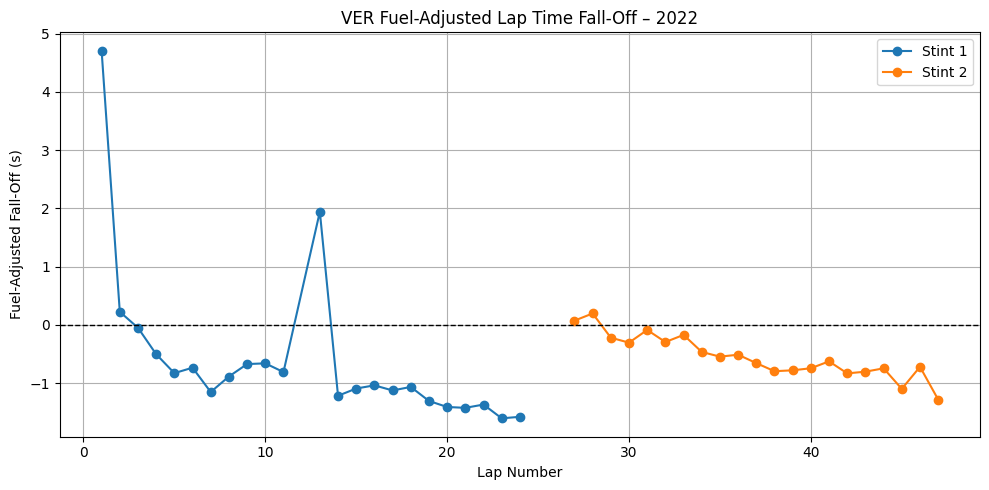

In [49]:
# Visualize VER in 2022
plot_fuel_adjusted_falloff('VER', 2022)

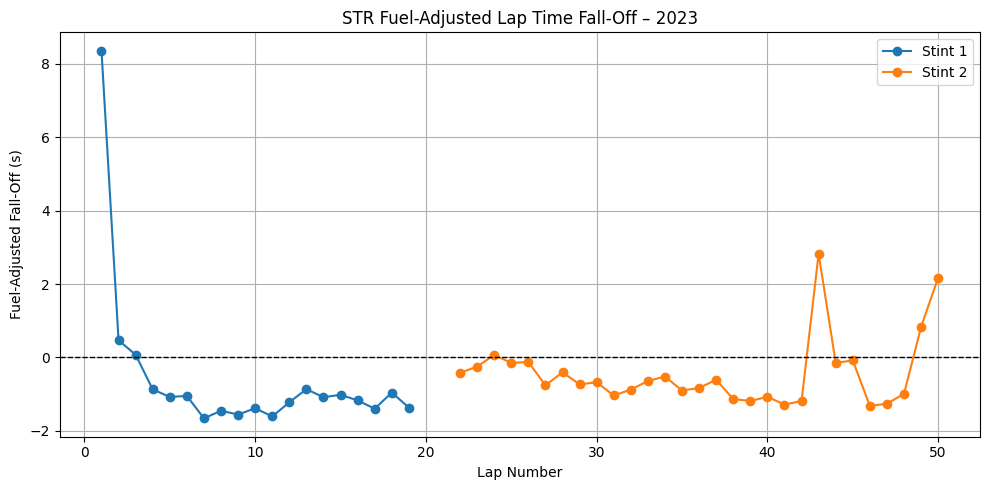

In [50]:
# Visualize STR in 2023
plot_fuel_adjusted_falloff('STR', 2023)

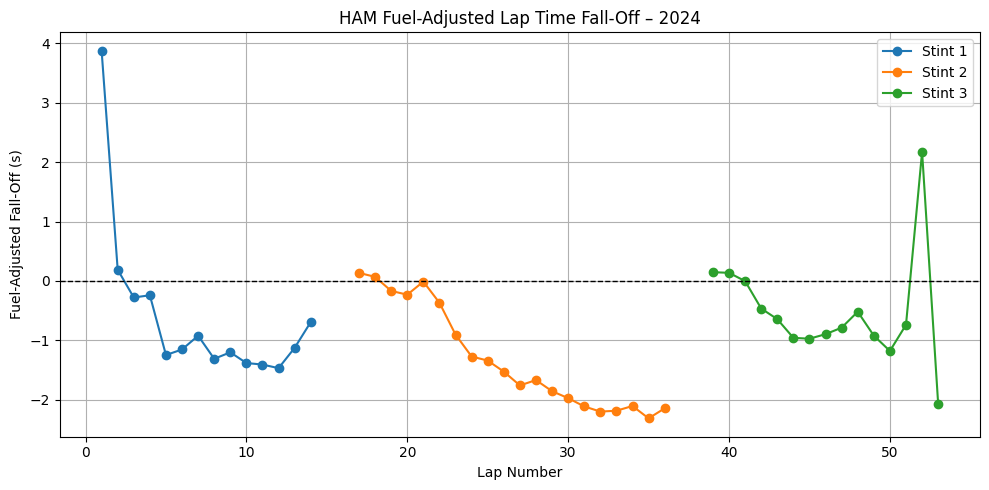

In [51]:
# Visualize HAM in 2024
plot_fuel_adjusted_falloff('HAM', 2024)

Fuel adjusted lap time fall off is not a good label for tyre wear.<br>
Pivot to including 'TyreLife' in the target.

In [52]:
final_df['TyreLife'].describe()

count    2647.000000
mean       13.437099
std         8.363964
min         1.000000
25%         7.000000
50%        12.000000
75%        19.000000
max        43.000000
Name: TyreLife, dtype: float64

In [53]:
final_df[
    (final_df['Driver'] == 'VER') &
    (final_df['Year'] == 2022)
][['Stint', 'TyreLife', 'LapNumber', 'Compound', 'FreshTyre']]

,Stint,TyreLife,LapNumber,Compound,FreshTyre
0,1.0,1.0,1.0,SOFT,True
23,1.0,2.0,2.0,SOFT,True
42,1.0,3.0,3.0,SOFT,True
62,1.0,4.0,4.0,SOFT,True
82,1.0,5.0,5.0,SOFT,True
101,1.0,6.0,6.0,SOFT,True
121,1.0,7.0,7.0,SOFT,True
140,1.0,8.0,8.0,SOFT,True
159,1.0,9.0,9.0,SOFT,True
179,1.0,10.0,10.0,SOFT,True


In [54]:
final_df[
    (final_df['Driver'] == 'STR') &
    (final_df['Year'] == 2022)
][['Stint', 'TyreLife', 'LapNumber', 'Compound', 'FreshTyre']]

,Stint,TyreLife,LapNumber,Compound,FreshTyre
3,1.0,2.0,1.0,MEDIUM,False
30,1.0,3.0,2.0,MEDIUM,False
49,1.0,4.0,3.0,MEDIUM,False
69,1.0,5.0,4.0,MEDIUM,False
89,1.0,6.0,5.0,MEDIUM,False
109,1.0,7.0,6.0,MEDIUM,False
130,1.0,8.0,7.0,MEDIUM,False
149,1.0,9.0,8.0,MEDIUM,False
168,1.0,10.0,9.0,MEDIUM,False
188,1.0,11.0,10.0,MEDIUM,False


In [55]:
final_df_copy.columns

Index(['Driver', 'Year', 'LapNumber', 'Stint', 'TyreLife', 'FreshTyre',
       'Compound', 'TrackTemp', 'AirTemp', 'Humidity', 'WindSpeed', 'Pressure',
       'Speed_Mean', 'Speed_Max', 'Speed_Std', 'Throttle_Mean', 'Throttle_Std',
       'Brake_Mean', 'RPM_Mean', 'Gear_Mean', 'DRS_active_pct', 'Team',
       'Position', 'LapTimeSeconds'],
      dtype='object')

In [56]:
final_df_copy['Compound'].value_counts()

Compound
HARD      1424
MEDIUM    1058
SOFT       165
Name: count, dtype: int64

In [57]:
compound_thresholds = {
    'SOFT':   {'low': 4,  'high': 10},
    'MEDIUM': {'low': 6,  'high': 14},
    'HARD':   {'low': 8,  'high': 18},
}

In [58]:
def classify_degradation(row):
    compound = row['Compound'].upper()
    tyrelife = row['TyreLife']

    thresholds = compound_thresholds[compound]

    # High degradation: old tyre
    if tyrelife >= thresholds['high']:
        return 'high'

    # Low degradation: young tyre
    elif tyrelife <= thresholds['low']:
        return 'low'

    # Medium otherwise
    else:
        return 'medium'

In [59]:
final_df_copy['DegradationClass'] = final_df_copy.apply(classify_degradation, axis=1)

In [60]:
final_df_copy['DegradationClass'].value_counts()

DegradationClass
high      977
medium    951
low       719
Name: count, dtype: int64

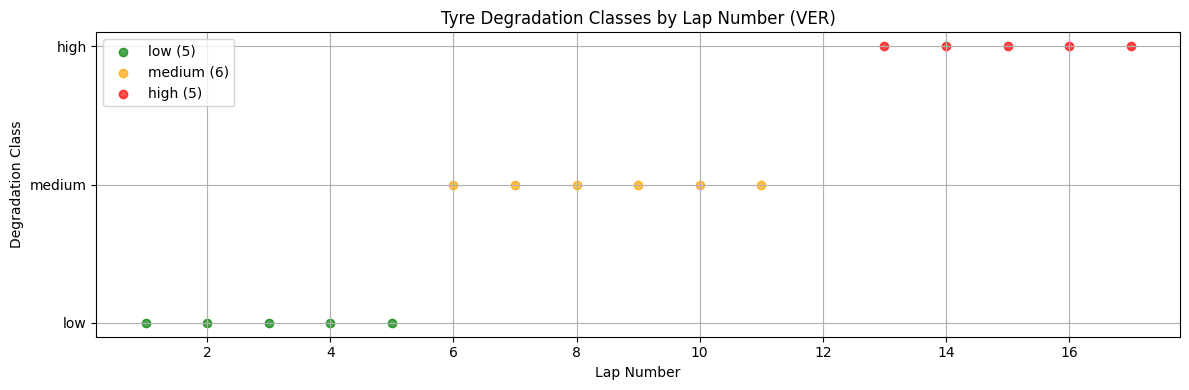

In [61]:
# Filter for one driver, year, and race for clarity
driver_df = final_df_copy[
                (final_df['Driver'] == 'STR') &
                (final_df['Year'] == 2022) &
                (final_df['Stint'] == 1)
            ]

# Set colors for each class
color_map = {'low': 'green', 'medium': 'orange', 'high': 'red'}

plt.figure(figsize=(12, 4))

# Plot each class
for cls in ['low', 'medium', 'high']:
    subset = driver_df[driver_df['DegradationClass'] == cls]
    plt.scatter(subset['LapNumber'], [cls]*len(subset), 
                label=f'{cls} ({len(subset)})', 
                color=color_map[cls], alpha=0.7)

plt.xlabel('Lap Number')
plt.ylabel('Degradation Class')
plt.title('Tyre Degradation Classes by Lap Number (VER)')
plt.yticks(['low', 'medium', 'high'])
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Classification or Regression:
Binned 'TyreLife' or number

In [62]:
# TyreLife-based label
final_df_copy.columns

Index(['Driver', 'Year', 'LapNumber', 'Stint', 'TyreLife', 'FreshTyre',
       'Compound', 'TrackTemp', 'AirTemp', 'Humidity', 'WindSpeed', 'Pressure',
       'Speed_Mean', 'Speed_Max', 'Speed_Std', 'Throttle_Mean', 'Throttle_Std',
       'Brake_Mean', 'RPM_Mean', 'Gear_Mean', 'DRS_active_pct', 'Team',
       'Position', 'LapTimeSeconds', 'DegradationClass'],
      dtype='object')

#### Clean Feature Set

In [63]:
# Select only weather-related columns
weather_cols = ['TrackTemp', 'AirTemp', 'Humidity', 'WindSpeed', 'Pressure']
weather_stats = final_df[weather_cols].describe().T

# Add a column for standard deviation as % of mean (to assess variation)
weather_stats['% StdDev of Mean'] = (weather_stats['std'] / weather_stats['mean']) * 100

# Display the stats
weather_stats[['mean', 'std', 'min', 'max', '% StdDev of Mean']]

,mean,std,min,max,% StdDev of Mean
TrackTemp,44.368757,2.150019,40.8,51.7,4.845794
AirTemp,30.393351,1.939918,27.7,33.9,6.382705
Humidity,34.604836,4.482377,30.0,43.0,12.953038
WindSpeed,1.534907,0.430408,0.4,2.4,28.041308
Pressure,995.495315,3.435036,992.5,1000.5,0.345058


In [64]:
# Remove weather data for single track
final_df_copy = final_df_copy.drop(columns=weather_cols)

In [65]:
# Remove TyreLife, LapNumber to prevent target leakage
final_df_copy = final_df_copy.drop(columns=['TyreLife', 'LapNumber'])

In [66]:
# Remove Team to reduce redundancy with Driver feature
final_df_copy = final_df_copy.drop(columns=['Team'])

In [67]:
# Years 2022-2024 are of the same car generation (with minor tweaks). Drop to reduce noise
final_df_copy = final_df_copy.drop(columns=['Year'])

In [68]:
# Could bias model toward track traffic patterns
final_df_copy = final_df_copy.drop(columns=['Position'])

In [69]:
final_df_copy.columns

Index(['Driver', 'Stint', 'FreshTyre', 'Compound', 'Speed_Mean', 'Speed_Max',
       'Speed_Std', 'Throttle_Mean', 'Throttle_Std', 'Brake_Mean', 'RPM_Mean',
       'Gear_Mean', 'DRS_active_pct', 'LapTimeSeconds', 'DegradationClass'],
      dtype='object')

Why these features?
- Driver: Needed to model driver tendencies
- Stint: Adds context across the race
- FreshTyre: Important tyre wear signal
- Compound: Critical for degradation model
- (Telemetry features): Driving behavior signal
- LapTimeSeconds: Useful signal of performance
- DegradationClass: Target label based on TyreLife

---

#### Encode Categorical Features

In [70]:
df = final_df_copy.copy()

In [71]:
# Apply custom mapping for label encoding
custom_label_map = {'low': 0, 'medium': 1, 'high': 2}
df['DegradationClass'] = df['DegradationClass'].map(custom_label_map)

print(df['DegradationClass'].value_counts())

DegradationClass
2    977
1    951
0    719
Name: count, dtype: int64


In [72]:
# One-hot encoding
categorical_cols = ['Driver', 'Compound', 'FreshTyre']
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

print("Encoded shape:", df_encoded.shape)
print("Encoded columns:", df_encoded.columns.tolist())

Encoded shape: (2647, 40)
Encoded columns: ['Stint', 'Speed_Mean', 'Speed_Max', 'Speed_Std', 'Throttle_Mean', 'Throttle_Std', 'Brake_Mean', 'RPM_Mean', 'Gear_Mean', 'DRS_active_pct', 'LapTimeSeconds', 'DegradationClass', 'Driver_ALO', 'Driver_BOT', 'Driver_COL', 'Driver_DEV', 'Driver_GAS', 'Driver_HAM', 'Driver_HUL', 'Driver_LAT', 'Driver_LAW', 'Driver_LEC', 'Driver_MAG', 'Driver_MSC', 'Driver_NOR', 'Driver_OCO', 'Driver_PER', 'Driver_PIA', 'Driver_RIC', 'Driver_RUS', 'Driver_SAI', 'Driver_SAR', 'Driver_STR', 'Driver_TSU', 'Driver_VER', 'Driver_VET', 'Driver_ZHO', 'Compound_MEDIUM', 'Compound_SOFT', 'FreshTyre_True']


In [73]:
df_encoded.head()

,Stint,Speed_Mean,Speed_Max,Speed_Std,Throttle_Mean,Throttle_Std,Brake_Mean,RPM_Mean,Gear_Mean,DRS_active_pct,...,Driver_SAI,Driver_SAR,Driver_STR,Driver_TSU,Driver_VER,Driver_VET,Driver_ZHO,Compound_MEDIUM,Compound_SOFT,FreshTyre_True
0,1.0,217.158358,316.0,78.673365,70.214076,42.652818,0.199413,10427.568915,5.363636,1.0,...,False,False,False,False,True,False,False,False,True,True
1,1.0,211.614286,325.0,79.339012,70.942857,41.055238,0.180000,10438.362857,5.060000,1.0,...,False,False,False,False,False,False,False,True,False,True
2,1.0,222.798193,311.0,75.100687,75.391566,38.674374,0.147590,10379.108434,5.713855,1.0,...,False,False,False,False,False,False,False,False,True,True
3,1.0,208.723464,323.0,80.000729,63.821229,42.078310,0.000000,10063.888268,5.505587,1.0,...,False,False,True,False,False,False,False,True,False,False
4,1.0,208.480556,326.0,80.934512,67.425000,41.964834,0.202778,10078.941667,5.383333,1.0,...,False,False,False,False,False,False,False,True,False,True


In [74]:
numeric_cols = [
    'Stint', 'Speed_Mean', 'Speed_Max', 'Speed_Std',
    'Throttle_Mean', 'Throttle_Std', 'Brake_Mean', 'RPM_Mean',
    'Gear_Mean', 'DRS_active_pct', 'LapTimeSeconds'
]

In [75]:
# Create a copy to avoid modifying original
X = df_encoded.drop(columns=['DegradationClass'])
y = df_encoded['DegradationClass']

# Standardize numeric columns
scaler = StandardScaler()
X[numeric_cols] = scaler.fit_transform(X[numeric_cols])

print(X[numeric_cols].describe())

              Stint    Speed_Mean     Speed_Max     Speed_Std  Throttle_Mean  \
count  2.647000e+03  2.647000e+03  2.647000e+03  2.647000e+03   2.647000e+03   
mean   1.288479e-16  2.491060e-15 -1.954194e-15  3.221199e-17   2.340738e-15   
std    1.000189e+00  1.000189e+00  1.000189e+00  1.000189e+00   1.000189e+00   
min   -1.104284e+00 -6.267918e+00 -3.509788e+00 -3.847524e+00  -6.080636e+00   
25%   -1.104284e+00 -4.317755e-01 -7.288718e-01 -6.126265e-01  -6.396060e-01   
50%    4.580034e-01 -1.735577e-03 -9.684545e-02 -4.451892e-02   2.273240e-02   
75%    4.580034e-01  5.216912e-01  5.351809e-01  5.620707e-01   6.979762e-01   
max    3.582578e+00  2.489339e+00  3.821718e+00  4.356549e+00   2.545197e+00   

       Throttle_Std    Brake_Mean      RPM_Mean     Gear_Mean  DRS_active_pct  \
count  2.647000e+03  2.647000e+03  2.647000e+03  2.647000e+03    2.647000e+03   
mean  -2.115254e-15  2.335369e-16 -8.783135e-15 -3.392996e-15   -6.442397e-17   
std    1.000189e+00  1.000189e+00  1

In [76]:
X.head()

,Stint,Speed_Mean,Speed_Max,Speed_Std,Throttle_Mean,Throttle_Std,Brake_Mean,RPM_Mean,Gear_Mean,DRS_active_pct,...,Driver_SAI,Driver_SAR,Driver_STR,Driver_TSU,Driver_VER,Driver_VET,Driver_ZHO,Compound_MEDIUM,Compound_SOFT,FreshTyre_True
0,-1.104284,-3.638393,-2.119330,1.637087,-1.139625,1.578750,1.703947,-0.570585,-3.959825,0.313875,...,False,False,False,False,True,False,False,False,True,True
1,-1.104284,-4.547006,-0.981682,1.857328,-0.886009,0.526002,0.984701,-0.496068,-5.474066,0.313875,...,False,False,False,False,False,False,False,True,False,True
2,-1.104284,-2.714086,-2.751356,0.455003,0.662144,-1.042902,-0.216037,-0.905136,-2.213275,0.313875,...,False,False,False,False,False,False,False,False,True,True
3,-1.104284,-5.020781,-1.234493,2.076269,-3.364339,1.200170,-5.684080,-3.081284,-3.251916,0.313875,...,False,False,True,False,False,False,False,True,False,False
4,-1.104284,-5.060591,-0.855277,2.385228,-2.110225,1.125393,1.828590,-2.977362,-3.861595,0.313875,...,False,False,False,False,False,False,False,True,False,True


#### Split Data

In [77]:
# Step 1: Split off test set (15%)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y,
    test_size=0.15,
    random_state=111,
    stratify=y
)

# Step 2: Split remaining into train and validation (85% → 70/15)
# 0.176 is ~15% of the original full set (0.15 / 0.85)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=0.176,
    random_state=111,
    stratify=y_temp
)

print("Train:", X_train.shape)
print("Validation:", X_val.shape)
print("Test:", X_test.shape)

Train: (1853, 39)
Validation: (396, 39)
Test: (398, 39)


#### Train Baseline Using RandomForest

In [88]:
# Train basic Random Forest
rf_base = RandomForestClassifier(random_state=111)
rf_base.fit(X_train, y_train)

# Predict on validation set
y_val_pred = rf_base.predict(X_val)

# Evaluate performance
print("Baseline Model Performance (Random Forest):\n")
print(confusion_matrix(y_val, y_val_pred))
print(classification_report(y_val, y_val_pred, target_names=['low', 'medium', 'high']))

Baseline Model Performance (Random Forest):

[[51 48  9]
 [19 82 41]
 [12 38 96]]
              precision    recall  f1-score   support

         low       0.62      0.47      0.54       108
      medium       0.49      0.58      0.53       142
        high       0.66      0.66      0.66       146

    accuracy                           0.58       396
   macro avg       0.59      0.57      0.57       396
weighted avg       0.59      0.58      0.58       396



In [89]:
# Hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'max_features': ['sqrt', 'log2']
}

rf_search = RandomizedSearchCV(
    estimator=rf_base,
    param_distributions=param_grid,
    n_iter=54,
    cv=4,
    scoring='accuracy',
    random_state=111,
    verbose=1,
    n_jobs=-1
)

rf_search.fit(X_train, y_train)
print("Best RF Params:", rf_search.best_params_)

Fitting 4 folds for each of 54 candidates, totalling 216 fits
Best RF Params: {'n_estimators': 300, 'min_samples_split': 2, 'max_features': 'sqrt', 'max_depth': 30}


In [90]:
# Predict on validation set
y_val_pred_tuned = rf_search.predict(X_val)

# Evaluate performance
print("Tuned Model Performance (Random Forest):\n")
print(confusion_matrix(y_val, y_val_pred_tuned))
print(classification_report(y_val, y_val_pred_tuned, target_names=['low', 'medium', 'high']))

Tuned Model Performance (Random Forest):

[[51 47 10]
 [17 79 46]
 [ 9 40 97]]
              precision    recall  f1-score   support

         low       0.66      0.47      0.55       108
      medium       0.48      0.56      0.51       142
        high       0.63      0.66      0.65       146

    accuracy                           0.57       396
   macro avg       0.59      0.56      0.57       396
weighted avg       0.59      0.57      0.57       396



#### Train XGBoost Classifier

In [91]:
# XGBoost with reasonable default params
xgb_base = XGBClassifier(
    objective='multi:softmax',
    num_class=3,
    eval_metric='mlogloss',
    random_state=111
)

xgb_base.fit(X_train, y_train)

# Predict on validation set
y_val_pred_xgb = xgb_base.predict(X_val)

# Evaluate
print("XGBoost Performance:\n")
print(confusion_matrix(y_val, y_val_pred_xgb))
print(classification_report(y_val, y_val_pred_xgb, target_names=['low', 'medium', 'high']))

XGBoost Performance:

[[51 40 17]
 [25 69 48]
 [15 33 98]]
              precision    recall  f1-score   support

         low       0.56      0.47      0.51       108
      medium       0.49      0.49      0.49       142
        high       0.60      0.67      0.63       146

    accuracy                           0.55       396
   macro avg       0.55      0.54      0.54       396
weighted avg       0.55      0.55      0.55       396



In [ ]:
# Hyperparameter tuning
xgb_param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2, 1],
    'min_child_weight': [1, 3, 5]
}

xgb_search = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=xgb_param_grid,
    n_iter=50,
    cv=4,
    scoring='f1_weighted',
    verbose=1,
    n_jobs=-1,
    random_state=111
)

xgb_search.fit(X_train, y_train)

Fitting 4 folds for each of 50 candidates, totalling 200 fits


RandomizedSearchCV(cv=4,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='mlogloss',
                                           feature_types=None,
                                           feature_weights=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_con...
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_class=3, ...),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'gamma': [0, 0.1, 0.2, 1],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.2],
                                        'max_depth': [3, 5, 10],
                                        'min_child_weight': [1, 3, 5],
                                        'n_estimators': [100, 200, 500],
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=111, scoring='f1_weighted', verbose=1)

In [98]:
best_xgb = xgb_search.best_estimator_

# Predict and evaluate
y_val_pred_xgb_tuned = best_xgb.predict(X_val)

print("Best Parameters:", xgb_search.best_params_)
print("\nTuned XGBoost Performance:\n")
print(confusion_matrix(y_val, y_val_pred_xgb_tuned))
print(classification_report(y_val, y_val_pred_xgb_tuned, target_names=['low', 'medium', 'high']))

Best Parameters: {'subsample': 1.0, 'n_estimators': 500, 'min_child_weight': 1, 'max_depth': 10, 'learning_rate': 0.01, 'gamma': 1, 'colsample_bytree': 1.0}

Tuned XGBoost Performance:

[[ 49  44  15]
 [ 24  64  54]
 [ 14  22 110]]
              precision    recall  f1-score   support

         low       0.56      0.45      0.50       108
      medium       0.49      0.45      0.47       142
        high       0.61      0.75      0.68       146

    accuracy                           0.56       396
   macro avg       0.56      0.55      0.55       396
weighted avg       0.56      0.56      0.56       396

